In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import scipy.signal as sps
import matplotlib.ticker as ticker
import pandas as pd
from scipy import stats
from torch.optim.lr_scheduler import ReduceLROnPlateau
%matplotlib inline

In [2]:
n_signals = 9

In [3]:
ca1 = []
ca3 = []
for i in range(n_signals):
    ca1.append(np.load("data/ca1_3_" + str(i) + ".npy"))
    ca3.append(np.load("data/ca3_3_" + str(i) + ".npy"))   
    
ca1 = np.array(ca1)
ca3 = np.array(ca3)

In [4]:
def gausFilter(signal, sigma = 35):
    min1 = np.min(signal)
    gf = gaussian_filter(signal, sigma)
    min2 = np.min(gf)
    return gf*min1/min2

In [5]:
for i in range(n_signals):
    ca1[i] = gausFilter(ca1[i])
    ca3[i] = gausFilter(ca3[i])    

In [6]:
train_ca1 = ca1[1:].copy()
test_ca1 = ca1[0].copy()

train_ca3 = ca3[1:].copy()
test_ca3 = ca3[0].copy()

for i in range(len(train_ca1)):
    train_ca1[i] = (train_ca1[i] - train_ca1[i].mean()) / train_ca1[i].std()
    train_ca3[i] = (train_ca3[i] - train_ca3[i].mean()) / train_ca3[i].std() 
    
# for i in range(len(test_ca1)):
#     test_ca1[i] = (test_ca1[i] - test_ca1[i].mean()) / test_ca1[i].std()
#     test_ca3[i] = (test_ca3[i] - test_ca3[i].mean()) / test_ca3[i].std()
    

test_ca1 = (test_ca1 - test_ca1.mean()) / test_ca1.std()
test_ca3 = (test_ca3 - test_ca3.mean()) / test_ca3.std()

In [8]:
import os

array = os.listdir("./metrics/")

In [12]:
min_interval = 1e9
min_border = 1e9
min_loss = 1e9

min_loss_params = None
min_interval_params = None
min_border_params = None

for filename in array:
    if "interval" in filename and "metric" in filename:
        metric = np.load("./metrics/" + filename)
        if metric < min_interval:
            min_interval = metric
            min_interval_params = filename
    if "border" in filename and "metric" in filename:
        metric = np.load("./metrics/" + filename)
        if metric < min_border:
            min_border = metric
            min_border_params = filename
    if "loss" in filename:
        loss = np.load("./metrics/" + filename)
        if loss < min_loss:
            min_loss = loss
            min_loss_params = filename

In [10]:
min_loss_params

'win50batch64n_hidden100dropout0.2num_layers2intervalloss.npy'

In [13]:
min_interval_params

'win50batch64n_hidden200dropout0.2num_layers3intervalmetric.npy'

In [14]:
min_border_params

'win1000batch4n_hidden200dropout0.1num_layers2bordersmetric.npy'

In [23]:
MAXLEN = 12000

In [15]:
h_params_interval = [64, 50, 200, 0.2, 3, "interval"]
h_params_loss = [64, 50, 100, 0.2, 2, "interval"]
h_params_border = [4, 1000, 200, 0.1, 2, "border"]

In [17]:
def create_inout_sequences(input_data, target_data, tw, hop, batch_size=64):
    inout_seq = []
    L = len(input_data)
    for i in range(0, L - max(batch_size,train_window), hop):
        train_seq = input_data[i:i+tw]
        train_label = target_data[i:i+tw]
        inout_seq.append((torch.FloatTensor(train_seq), torch.FloatTensor(train_label)))
    return inout_seq

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, 
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(2*hidden_layer_size, output_size)


    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # layer 2
        x = self.dropout(lstm_out)
        predictions = self.linear_2(x)
        return predictions

In [19]:
def GetWeitsWin(concat_len):
    y_data = stats.norm.pdf(np.arange(0, concat_len, 1), 0, concat_len/5)
    y_data2 = stats.norm.pdf(np.arange(-concat_len, 0, 1), 0, concat_len/5)

    weights = np.concatenate((np.expand_dims(y_data, axis=1), np.expand_dims(y_data2, axis=1)), axis=1)
    weights = weights / np.expand_dims(weights.sum(axis=1), axis=1)
    return weights

In [20]:
def SmoothSignal(signal, win, hop):
    #now support only win // hop = 2
    sm_signal = []
    weights = GetWeitsWin(hop)
    sm_signal.append(signal[:hop])
    for w in range(0, len(signal) - win, win):
        left_signal = signal[w+(win-hop):w+win] * weights[:, 0]
        right_signal = signal[w+win:w+win+hop] * weights[:, 1]
           
        sm_signal.append(left_signal + right_signal)
    #sm_signal.append(signal[w+win+hop: w+2*win])
        
    return np.array(sm_signal).flatten()

In [30]:
def GetPredSignal(model_lstm, win, hop, test_dataloader):
    preds = []
    model_lstm.eval()
    for idx, (x, y) in enumerate(tqdm(test_dataloader)):


            x = x[..., None].to('cuda')

            out = model_lstm(x)
            
            
            preds.append(out.detach().cpu().numpy().flatten())
    preds = np.array(preds).flatten()
    sm_preds = SmoothSignal(preds, win, hop)
    return sm_preds

In [24]:
def getAnswer(signal, maxlen=MAXLEN):
    left = right = np.argmin(signal)
    mean = np.mean(signal)
    while signal[left]<mean and left>0:
        left-=1
    while signal[right]<mean and right<maxlen:
        right+=1
    return [left, right]

#### now all times batch_size was 1000

## Interval

In [16]:
batch_size, train_window, n_hidden, dropout, n_layers, mode = h_params_interval
hop_len = train_window // 2

In [26]:
train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window, hop_len)
    

test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window, hop_len)

train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [28]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=1, dropout=dropout)
model_lstm = model_lstm.to('cuda')
model_lstm.load_state_dict(torch.load("./SearchHParams/BestMetric" + min_interval_params[:-10]))

<All keys matched successfully>

In [29]:
sm_preds = GetPredSignal(model_lstm, train_window, hop_len, test_dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

(19200,)


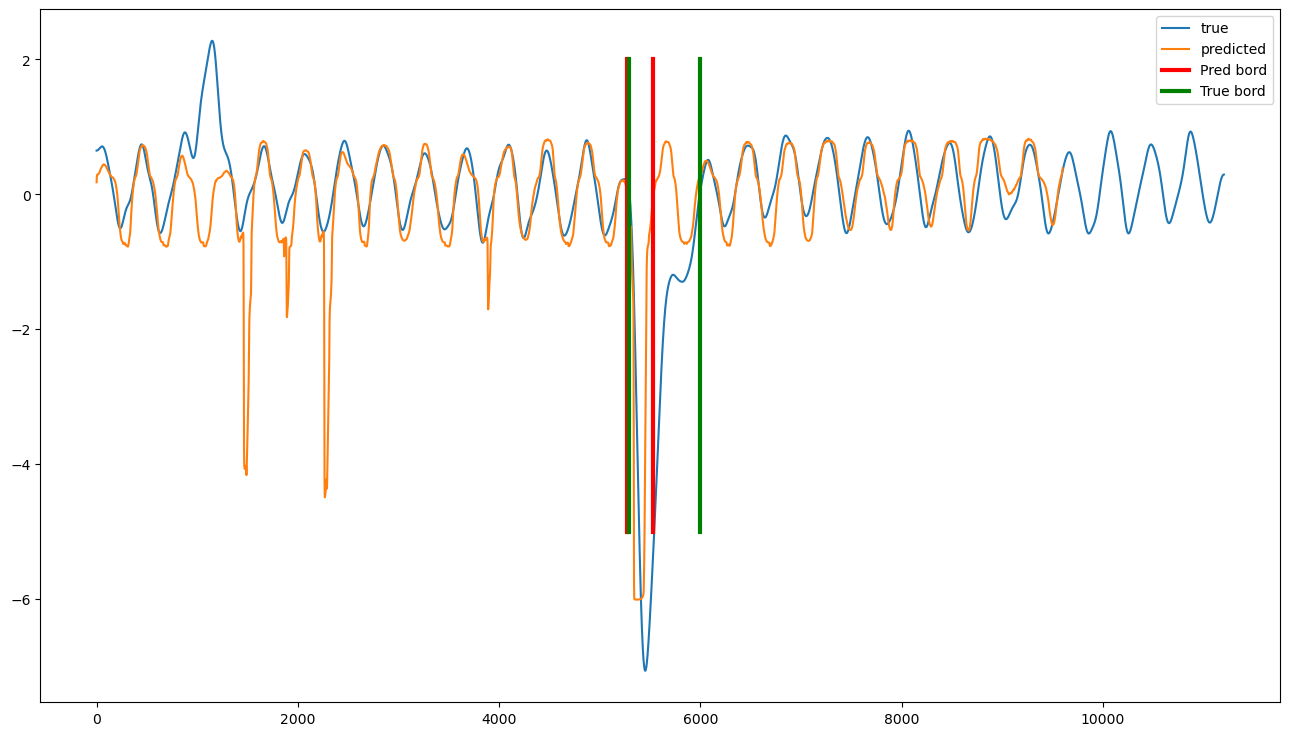

In [33]:
bord = getAnswer(sm_preds)
tr_bord = getAnswer(test_ca1)

plt.figure(figsize=(16, 9))

plt.plot(test_ca1, label="true")
plt.plot(sm_preds, label="predicted")
plt.plot([bord[0]]*2, [-5, 2], color="r", linewidth = 3, label="Pred bord")
plt.plot([bord[1]]*2, [-5, 2], color="r", linewidth = 3)
plt.plot([tr_bord[0]]*2, [-5, 2], color="g", linewidth = 3, label="True bord")
plt.plot([tr_bord[1]]*2, [-5, 2], color="g", linewidth = 3)


plt.legend()

## Border

In [34]:
batch_size, train_window, n_hidden, dropout, n_layers, mode = h_params_border
hop_len = train_window // 2

In [35]:
train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window, hop_len)
    

test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window, hop_len)

train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [36]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=1, dropout=dropout)
model_lstm = model_lstm.to('cuda')
model_lstm.load_state_dict(torch.load("./SearchHParams/BestMetric" + min_border_params[:-10]))

<All keys matched successfully>

In [37]:
sm_preds = GetPredSignal(model_lstm, train_window, hop_len, test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

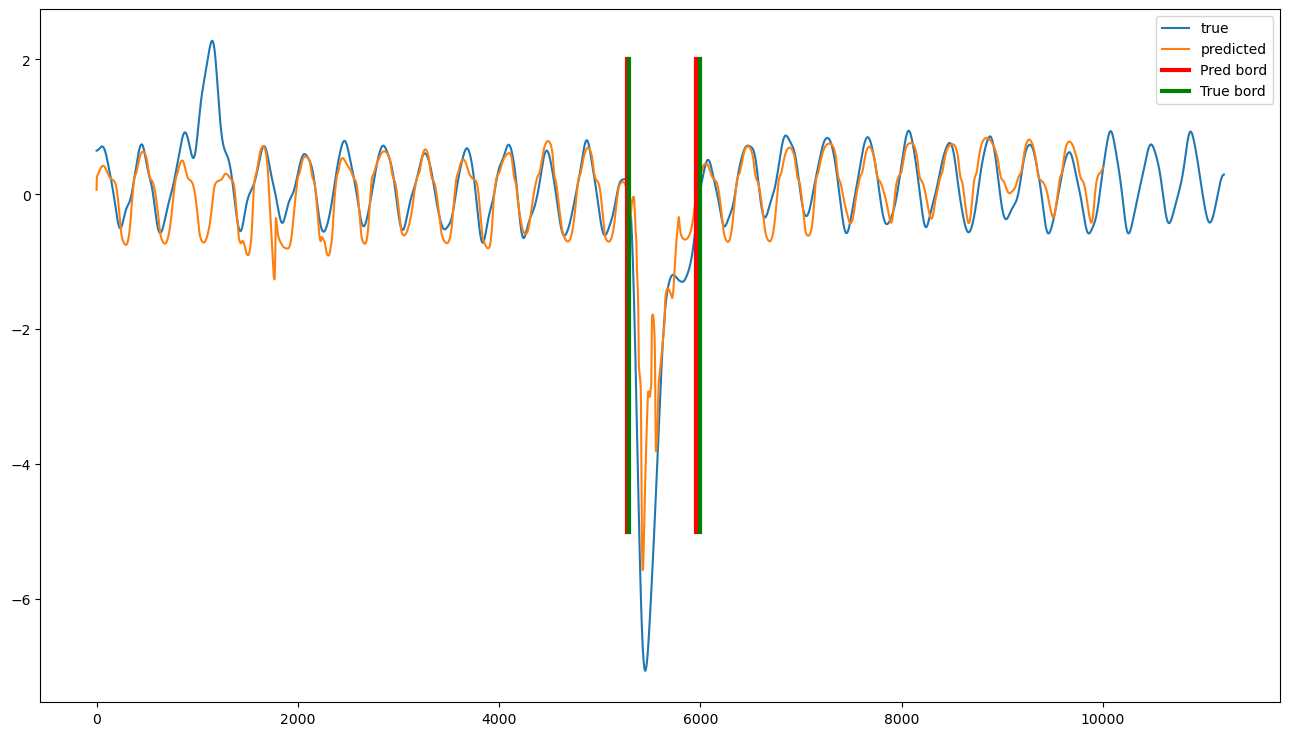

In [38]:
bord = getAnswer(sm_preds)
tr_bord = getAnswer(test_ca1)

plt.figure(figsize=(16, 9))

plt.plot(test_ca1, label="true")
plt.plot(sm_preds, label="predicted")
plt.plot([bord[0]]*2, [-5, 2], color="r", linewidth = 3, label="Pred bord")
plt.plot([bord[1]]*2, [-5, 2], color="r", linewidth = 3)
plt.plot([tr_bord[0]]*2, [-5, 2], color="g", linewidth = 3, label="True bord")
plt.plot([tr_bord[1]]*2, [-5, 2], color="g", linewidth = 3)


plt.legend()

## Loss

In [39]:
batch_size, train_window, n_hidden, dropout, n_layers, mode = h_params_loss
hop_len = train_window // 2

In [40]:
train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window, hop_len)
    

test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window, hop_len)

train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

In [41]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=n_hidden, num_layers=n_layers, output_size=1, dropout=dropout)
model_lstm = model_lstm.to('cuda')
model_lstm.load_state_dict(torch.load("./SearchHParams/BestLoss" + min_loss_params[:-8]))

<All keys matched successfully>

In [42]:
sm_preds = GetPredSignal(model_lstm, train_window, hop_len, test_dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

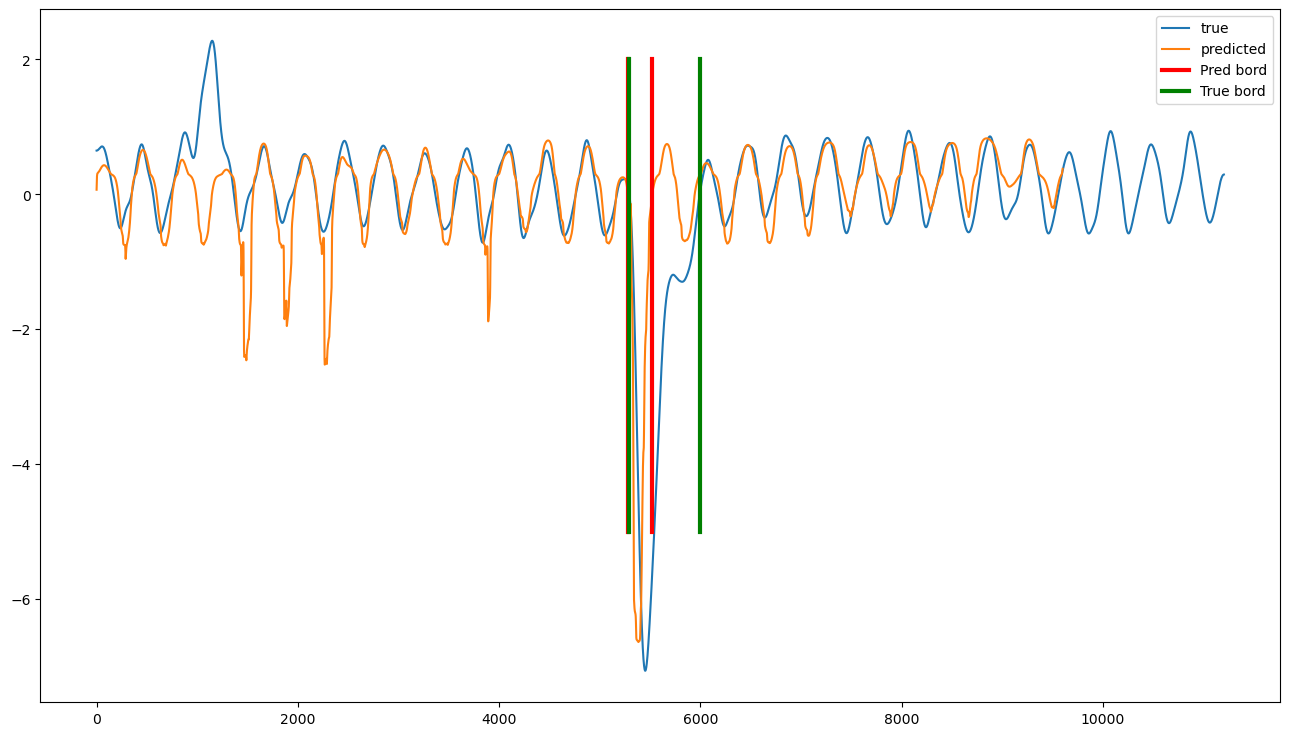

In [43]:
bord = getAnswer(sm_preds)
tr_bord = getAnswer(test_ca1)

plt.figure(figsize=(16, 9))

plt.plot(test_ca1, label="true")
plt.plot(sm_preds, label="predicted")
plt.plot([bord[0]]*2, [-5, 2], color="r", linewidth = 3, label="Pred bord")
plt.plot([bord[1]]*2, [-5, 2], color="r", linewidth = 3)
plt.plot([tr_bord[0]]*2, [-5, 2], color="g", linewidth = 3, label="True bord")
plt.plot([tr_bord[1]]*2, [-5, 2], color="g", linewidth = 3)


plt.legend()

## Best from the best

In [44]:
batch_size = 4
train_window = 1000
hop_len = train_window // 2

train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window, hop_len)
    

test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window, hop_len)

train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)

model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')
model_lstm.load_state_dict(torch.load("./SearchHParams/BestMetric"))

sm_preds = GetPredSignal(model_lstm, train_window, hop_len, test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

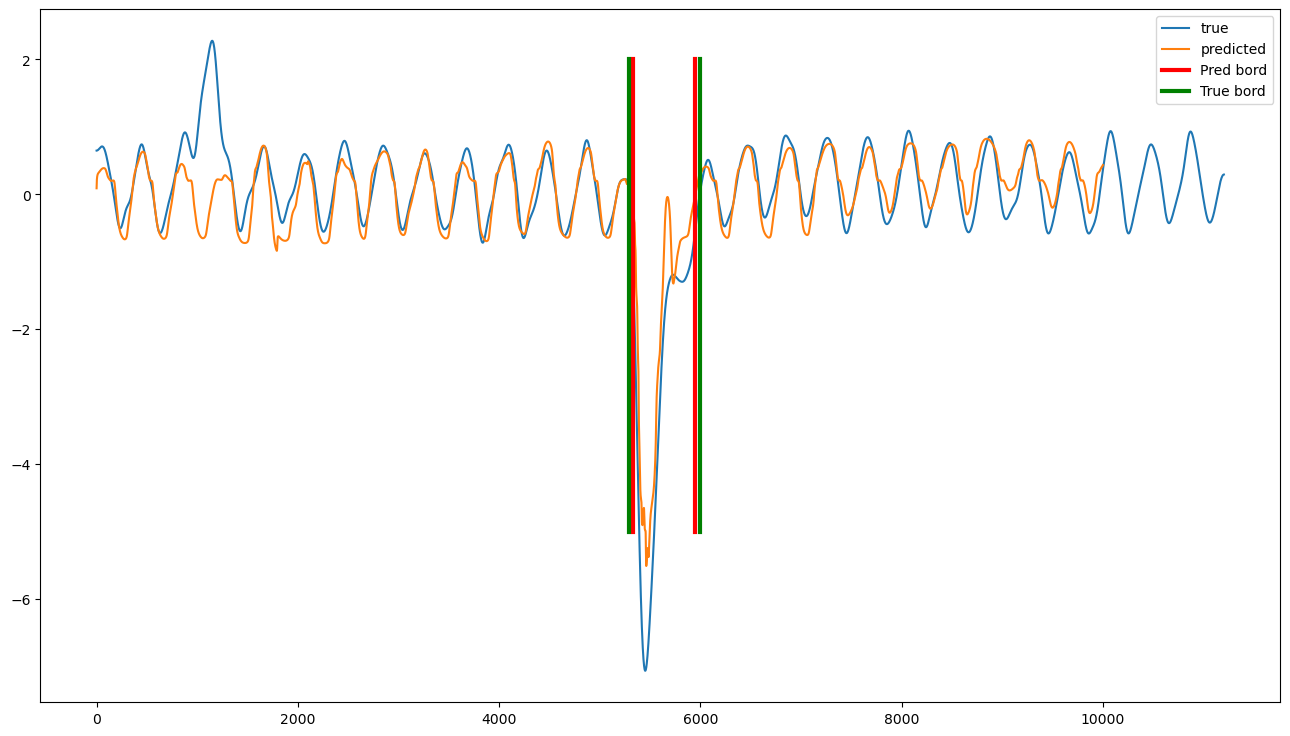

In [45]:
bord = getAnswer(sm_preds)
tr_bord = getAnswer(test_ca1)

plt.figure(figsize=(16, 9))

plt.plot(test_ca1, label="true")
plt.plot(sm_preds, label="predicted")
plt.plot([bord[0]]*2, [-5, 2], color="r", linewidth = 3, label="Pred bord")
plt.plot([bord[1]]*2, [-5, 2], color="r", linewidth = 3)
plt.plot([tr_bord[0]]*2, [-5, 2], color="g", linewidth = 3, label="True bord")
plt.plot([tr_bord[1]]*2, [-5, 2], color="g", linewidth = 3)


plt.legend()